In [45]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Create output folder
import os
#output_folder = "recommendations"
output_folder = "data/daily"

os.makedirs(output_folder, exist_ok=True)

In [46]:
# URLs
URL_GAINERS = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=day_gainers&count=250"
URL_ACTIVE = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=most_actives&count=250"
URL_TRENDING = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=trending_tickers&count=250"

In [47]:
def fetch_screener(scrId, count=250): 
    url = f"https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds={scrId}&count={count}"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading screener {scrId}: {e}")


In [ ]:
def fetch_trending():
    url = "https://query1.finance.yahoo.com/v1/finance/trending/US"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading trending {e}")

In [49]:
import re

def filter_equities(df):
    eq = []
    for s in df["symbol"]:
        if re.fullmatch(r"[A-Za-z][A-Za-z0-9\.-]{0,9}", s):
            eq.append(s)
    return pd.DataFrame({"symbol": eq})


In [50]:
print("Downloading Yahoo lists...")

df_gainers = fetch_screener("day_gainers")
df_active  = fetch_screener("most_actives")
df_trending_raw = fetch_trending()
df_trending = filter_equities(df_trending_raw)


print("Gainers:", len(df_gainers))
print("Most Active:", len(df_active))
print("Trending:", len(df_trending))

combined = pd.concat([df_gainers, df_active, df_trending], ignore_index=True)
combined.drop_duplicates(subset="symbol", inplace=True)

print("Total unique hot symbols:", len(combined))


Gainers: 107
Most Active: 250
Trending: 20
Total unique hot symbols: 333


In [51]:
def fix_num(x):
    """
    Convert Yahoo formatted numbers:
    '1.2M', '330K', '2.3B' → float
    """
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)

    x = str(x).replace(",", "")

    try:
        if x.endswith("M"):
            return float(x[:-1]) * 1e6
        if x.endswith("B"):
            return float(x[:-1]) * 1e9
        if x.endswith("K"):
            return float(x[:-1]) * 1e3
        return float(x)
    except:
        return np.nan

numeric_cols = [
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketChange",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap"
]

for col in numeric_cols:
    if col in combined.columns:
        combined[col] = combined[col].apply(fix_num)

In [52]:
df = combined.copy()

# Volume Spike Score
df["VolumeSpike"] = df["regularMarketVolume"] / df["averageDailyVolume3Month"]
df["VolumeScore"] = df["VolumeSpike"].rank(pct=True)

# Momentum Score (based on daily % change)
df["MomentumScore"] = df["regularMarketChangePercent"].rank(pct=True)

# Volatility Score (higher movement = more hot)
df["VolatilityScore"] = df["regularMarketChange"].abs().rank(pct=True)

# Trend Score (proxy: price vs avg volume)
df["TrendScore"] = (df["regularMarketPrice"] / (df["averageDailyVolume3Month"] + 1)).rank(pct=True)

# Final score
df["HotScore"] = (
    0.35 * df["MomentumScore"] +
    0.35 * df["VolumeScore"] +
    0.20 * df["VolatilityScore"] +
    0.10 * df["TrendScore"]
)

df.sort_values("HotScore", ascending=False, inplace=True)

# Keep relevant columns
output_df = df[[
    "symbol",
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap",
    "VolumeSpike",
    "MomentumScore",
    "VolumeScore",
    "VolatilityScore",
    "TrendScore",
    "HotScore"
]]

In [53]:
top50 = output_df.head(50)


timestamp = datetime.now().strftime("%Y%m%d%H%M%S") 
file_path = os.path.join(output_folder, f"hot_stocks_{timestamp}.csv")
top50.to_csv(file_path, index=False)

print("\n🔥 Saved TOP 50 hot stocks to:", file_path)
top50



🔥 Saved TOP 50 hot stocks to: data/daily\hot_stocks_20251118214912.csv


,symbol,regularMarketPrice,regularMarketChangePercent,regularMarketVolume,averageDailyVolume3Month,marketCap,VolumeSpike,MomentumScore,VolumeScore,VolatilityScore,TrendScore,HotScore
15,JAZZ,181.6500,6.796400,3465276.0,825357.0,1.103798e+10,4.198518,0.956790,0.987654,0.978395,0.981481,0.974383
17,BLTE,124.3300,6.346761,128837.0,67032.0,4.337997e+09,1.922022,0.938272,0.944444,0.959877,1.000000,0.950926
1,DGNX,16.1050,18.506250,2713231.0,767879.0,3.269402e+09,3.533410,0.996914,0.984568,0.830247,0.814815,0.941049
11,MSTR,208.7050,6.798180,17850900.0,12046590.0,5.997216e+10,1.481822,0.959877,0.901235,0.987654,0.793210,0.928241
6,AS,33.4998,8.907026,11659526.0,5230676.0,1.857803e+10,2.229067,0.978395,0.956790,0.842593,0.626543,0.908488
35,MDT,100.5200,4.403820,17904490.0,6931262.0,1.289286e+11,2.583150,0.873457,0.972222,0.913580,0.771605,0.905864
49,NTRA,213.9150,3.822074,1832480.0,1172681.0,2.952336e+10,1.562642,0.824074,0.907407,0.962963,0.978395,0.896451
22,GLBE,37.3050,6.191287,2312738.0,1367673.0,6.331632e+09,1.691002,0.935185,0.922840,0.787037,0.861111,0.893827
19,TERN,27.2100,6.455398,4774888.0,2393689.0,2.451071e+09,1.994782,0.941358,0.950617,0.762346,0.734568,0.888117
10,LQDA,30.4600,7.253519,4000743.0,2545590.0,2.649882e+09,1.571637,0.962963,0.910494,0.777778,0.740741,0.885340


In [54]:
top50['symbol']

15     JAZZ
17     BLTE
1      DGNX
11     MSTR
6        AS
35      MDT
49     NTRA
22     GLBE
19     TERN
10     LQDA
12     NBIS
2       LGN
33     HTFL
43      MRK
38     TIGO
8      SRRK
0      ONDS
81      MOH
27     ARQT
20     UPWK
9       JHX
73     PCAR
82     TMDX
31     CWAN
32     CHDN
63      TFX
7      QUBT
40     CNTA
24       MH
105    BFAM
46     WRBY
103    LGND
56     EXAS
57     WAFD
95      ALB
85     PARR
4      WULF
39     LSCC
106     HQY
326    BIDU
26     CGON
34     TARS
133     LNW
50     DECK
58     LMND
41     BMNR
80      VLO
62     NFLX
102    REGN
16     EOSE
Name: symbol, dtype: object

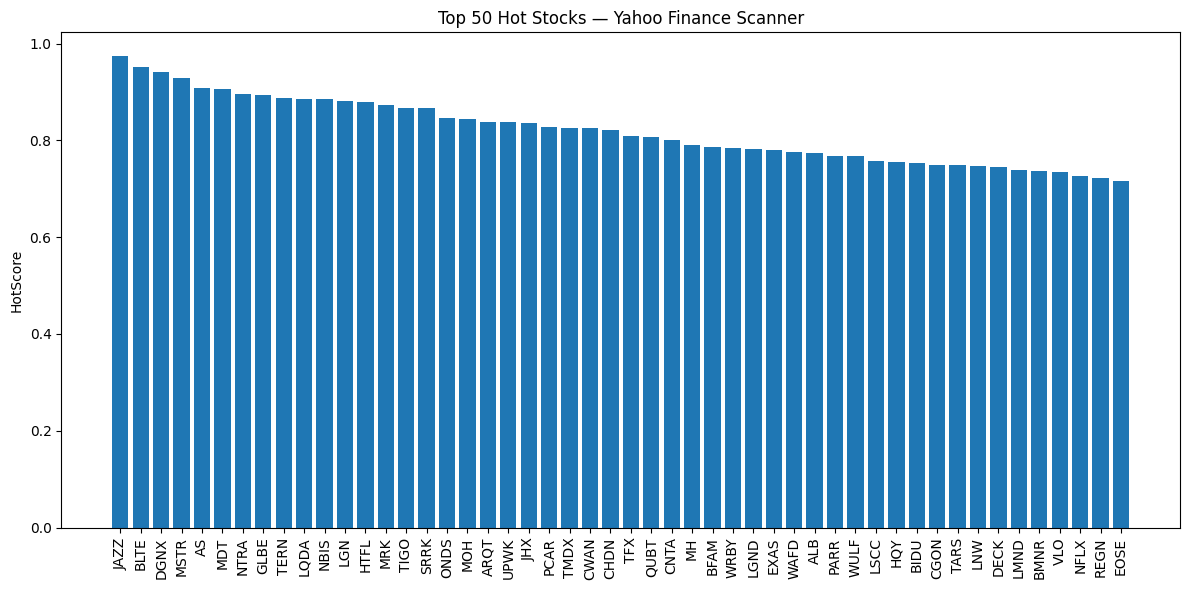

In [55]:

# --------------------------------------------------------
# 6. Plot Heat Bar
# --------------------------------------------------------

plt.figure(figsize=(12, 6))
plt.bar(top50["symbol"], top50["HotScore"])
plt.xticks(rotation=90)
plt.title("Top 50 Hot Stocks — Yahoo Finance Scanner")
plt.ylabel("HotScore")
plt.tight_layout()
plt.show()